<a href="https://colab.research.google.com/github/aljoharas/datascience/blob/main/spotifyproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Data Collection

In [34]:
!pip install spotipy


In [35]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.oauth2 import SpotifyOAuth
#hide our api key for safety
auth_manager = SpotifyClientCredentials()
sp = spotipy.Spotify(auth_manager=auth_manager)


In [36]:
import os
import requests


csv_urls = [
  "https://raw.githubusercontent.com/aljoharas/datascience/refs/heads/main/charts/regional-ae-weekly-2025-08-07.csv",
  "https://raw.githubusercontent.com/aljoharas/datascience/refs/heads/main/charts/regional-au-weekly-2025-08-07.csv",
  "https://raw.githubusercontent.com/aljoharas/datascience/refs/heads/main/charts/regional-br-weekly-2025-08-07.csv",
  "https://raw.githubusercontent.com/aljoharas/datascience/refs/heads/main/charts/regional-by-weekly-2025-08-07.csv",
  "https://raw.githubusercontent.com/aljoharas/datascience/refs/heads/main/charts/regional-ch-weekly-2025-08-07.csv",
  "https://raw.githubusercontent.com/aljoharas/datascience/refs/heads/main/charts/regional-eg-weekly-2025-08-07.csv",
  "https://raw.githubusercontent.com/aljoharas/datascience/refs/heads/main/charts/regional-gb-weekly-2025-08-07.csv",
  "https://raw.githubusercontent.com/aljoharas/datascience/refs/heads/main/charts/regional-global-weekly-2025-09-18.csv",
  "https://raw.githubusercontent.com/aljoharas/datascience/refs/heads/main/charts/regional-hk-weekly-2025-08-07.csv",
  "https://raw.githubusercontent.com/aljoharas/datascience/refs/heads/main/charts/regional-in-weekly-2025-08-07.csv",
  "https://raw.githubusercontent.com/aljoharas/datascience/refs/heads/main/charts/regional-it-weekly-2025-08-07.csv",
  "https://raw.githubusercontent.com/aljoharas/datascience/refs/heads/main/charts/regional-jp-weekly-2025-08-07.csv",
  "https://raw.githubusercontent.com/aljoharas/datascience/refs/heads/main/charts/regional-kr-weekly-2025-08-07.csv",
  "https://raw.githubusercontent.com/aljoharas/datascience/refs/heads/main/charts/regional-sa-weekly-2025-09-18.csv",
  "https://raw.githubusercontent.com/aljoharas/datascience/refs/heads/main/charts/regional-th-weekly-2025-08-07.csv",
  "https://raw.githubusercontent.com/aljoharas/datascience/refs/heads/main/charts/regional-tr-weekly-2025-08-07.csv",
  "https://raw.githubusercontent.com/aljoharas/datascience/refs/heads/main/charts/regional-tw-weekly-2025-08-07.csv",
  "https://raw.githubusercontent.com/aljoharas/datascience/refs/heads/main/charts/regional-us-weekly-2025-08-07.csv",
  "https://raw.githubusercontent.com/aljoharas/datascience/refs/heads/main/charts/regional-uy-weekly-2025-08-07.csv",
  "https://raw.githubusercontent.com/aljoharas/datascience/refs/heads/main/charts/regional-ve-weekly-2025-08-07.csv",
]

for url in csv_urls:
    filename = os.path.join("/content", url.split("/")[-1])
    if not os.path.exists(filename):
        r = requests.get(url)
        if r.status_code == 200:
            with open(filename, "wb") as f:
                f.write(r.content)
        else:
            print(f"Failed to download {url} — status code {r.status_code}")

import glob
chart_files = glob.glob("/content/regional-*.csv")
print(f"Found {len(chart_files)} chart files")

Found 20 chart files


In [37]:
import time
import pandas as pd # Import pandas here
for f in chart_files:
    df = pd.read_csv(f)
    print(f"{f}: columns = {df.columns.tolist()}")

#filter out directories
chart_files = [f for f in chart_files if os.path.isfile(f)]

print(f"Found {len(chart_files)} CSV files")


dfs = [pd.read_csv(f) for f in chart_files]
all_artists = pd.concat([df['artist_names'] for df in dfs]).unique()

print(f"Total unique artists across all charts: {len(all_artists)}")

/content/regional-eg-weekly-2025-08-07.csv: columns = ['rank', 'uri', 'artist_names', 'track_name', 'source', 'peak_rank', 'previous_rank', 'weeks_on_chart', 'streams']
/content/regional-hk-weekly-2025-08-07.csv: columns = ['rank', 'uri', 'artist_names', 'track_name', 'source', 'peak_rank', 'previous_rank', 'weeks_on_chart', 'streams']
/content/regional-tw-weekly-2025-08-07.csv: columns = ['rank', 'uri', 'artist_names', 'track_name', 'source', 'peak_rank', 'previous_rank', 'weeks_on_chart', 'streams']
/content/regional-th-weekly-2025-08-07.csv: columns = ['rank', 'uri', 'artist_names', 'track_name', 'source', 'peak_rank', 'previous_rank', 'weeks_on_chart', 'streams']
/content/regional-sa-weekly-2025-09-18.csv: columns = ['rank', 'uri', 'artist_names', 'track_name', 'source', 'peak_rank', 'previous_rank', 'weeks_on_chart', 'streams']
/content/regional-in-weekly-2025-08-07.csv: columns = ['rank', 'uri', 'artist_names', 'track_name', 'source', 'peak_rank', 'previous_rank', 'weeks_on_chart

In [38]:
import time
from spotipy.exceptions import SpotifyException
import requests
from requests.exceptions import ReadTimeout
import pandas as pd

artist_data = []
seen_ids = set()

for artist_name in all_artists:
    try:
        result = sp.search(q=f"artist:{artist_name}", type="artist", limit=1)
        if result['artists']['items']:
            a = result['artists']['items'][0]
            # skip if no genres or already seen
            if not a['genres'] or a['id'] in seen_ids:
                continue
            artist_data.append({
                "name": a['name'],
                "id": a['id'],
                "genres": a['genres'],
                "popularity": a['popularity']
            })
            seen_ids.add(a['id'])

        time.sleep(0.5)
    except (requests.exceptions.ConnectionError, SpotifyException, ReadTimeout) as e:
        print(f"Error fetching {artist_name}: {e}. Retrying in 5 seconds...")
        time.sleep(5)
        continue

#creating the dataframe
df_artists = pd.DataFrame(artist_data)


# Check for missing values
print("Missing values per column:\n", df_artists.isnull().sum())

# Drop duplicates based on artist ID
df_artists.drop_duplicates(subset='id', inplace=True)

# Convert genres list to comma-separated string for readability
df_artists['genres_str'] = df_artists['genres'].apply(lambda x: ', '.join(x))

# Confirm datatypes
print("\nData types after cleaning:\n", df_artists.dtypes)


print(f"Final dataset: {len(df_artists)} artists with non-empty genres")
display(df_artists)
output_path = "spotify_artists_cleaned.csv"
df_artists.to_csv(output_path, index=False, encoding='utf-8-sig')
print(f"CSV file saved successfully as '{output_path}'")




Missing values per column:
 name          0
id            0
genres        0
popularity    0
dtype: int64

Data types after cleaning:
 name          object
id            object
genres        object
popularity     int64
genres_str    object
dtype: object
Final dataset: 702 artists with non-empty genres


,name,id,genres,popularity,genres_str
0,Amr Diab,5abSRg0xN1NV3gLbuvX24M,"[egyptian pop, khaleeji]",71,"egyptian pop, khaleeji"
1,TUL8TE,5QKGejJMncXUNUb9pUFbEf,"[egyptian hip hop, arabic hip hop, egyptian po...",68,"egyptian hip hop, arabic hip hop, egyptian pop..."
2,Houda,3fyqTnSY7KwpOnO6zdHPVH,"[mahraganat, egyptian pop, egyptian shaabi]",56,"mahraganat, egyptian pop, egyptian shaabi"
3,مصطفي الجن و هادي الصغير - تيم الابداع,5ocZbmWp3jlpBeLOEgsFcc,"[mahraganat, egyptian pop]",58,"mahraganat, egyptian pop"
4,Essam Sasa,2KjiHtx0h8tyJXbg8aYRgu,"[mahraganat, egyptian pop, egyptian shaabi, eg...",67,"mahraganat, egyptian pop, egyptian shaabi, egy..."
...,...,...,...,...,...
697,Eminem,7dGJo4pcD2V6oG8kP0tJRR,"[rap, hip hop]",90,"rap, hip hop"
698,Pashanim,34LetYSjEuG2fBb4Z8PwPg,[german hip hop],74,german hip hop
699,The Animals,3ICflSq6ZgYAIrm2CTkfVP,[classic rock],67,classic rock
700,Provinz,2f7f3AmL16mmiAmYnxmmfx,"[german indie, german indie pop, german pop]",66,"german indie, german indie pop, german pop"


CSV file saved successfully as 'spotify_artists_cleaned.csv'


===== Step 1: Adding genre_count and categorizing artists =====
genre_count and genre_category added.

Sample data:


,name,id,genres,popularity,genres_str,genre_count,genre_category
0,Amr Diab,5abSRg0xN1NV3gLbuvX24M,"[egyptian pop, khaleeji]",71,"egyptian pop, khaleeji",2,multi-genre
1,TUL8TE,5QKGejJMncXUNUb9pUFbEf,"[egyptian hip hop, arabic hip hop, egyptian po...",68,"egyptian hip hop, arabic hip hop, egyptian pop...",4,multi-genre
2,Houda,3fyqTnSY7KwpOnO6zdHPVH,"[mahraganat, egyptian pop, egyptian shaabi]",56,"mahraganat, egyptian pop, egyptian shaabi",3,multi-genre
3,مصطفي الجن و هادي الصغير - تيم الابداع,5ocZbmWp3jlpBeLOEgsFcc,"[mahraganat, egyptian pop]",58,"mahraganat, egyptian pop",2,multi-genre
4,Essam Sasa,2KjiHtx0h8tyJXbg8aYRgu,"[mahraganat, egyptian pop, egyptian shaabi, eg...",67,"mahraganat, egyptian pop, egyptian shaabi, egy...",4,multi-genre


===== Step 2: Descriptive statistics by genre category =====
                count       mean        std  min   25%   50%   75%   max
genre_category                                                          
multi-genre     471.0  64.433121  12.828463  4.0  57.0  64.0  74.0  96.0
single-genre    231.0  61.190476  18.027952  0.0  48.5  64.0  75.0  97.0 

===== Descriptive Statistics =====


,popularity,genre_count
count,702.000000,702.000000
mean,63.366097,2.441595
std,14.808763,1.433801
min,0.000000,1.000000
25%,56.000000,1.000000
50%,64.000000,2.000000
75%,74.000000,3.000000
max,97.000000,8.000000


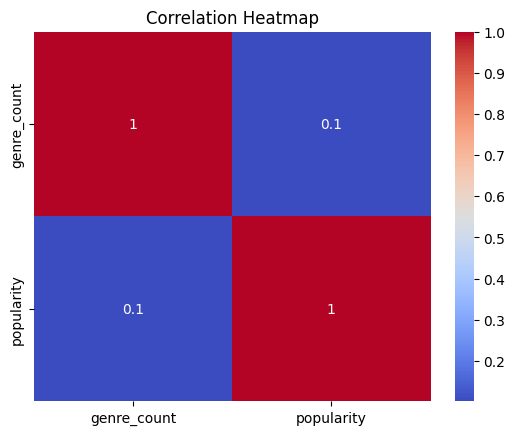

===== Step 3: Boxplot - Popularity by Genre Category =====


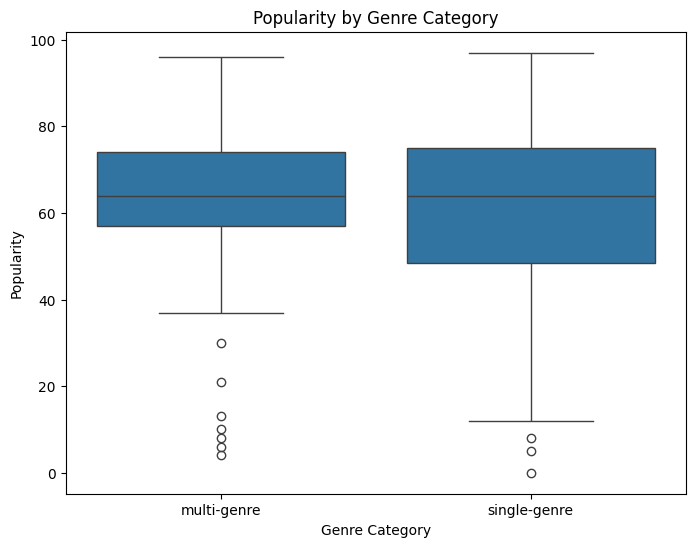

===== Step 4: Scatter plot - Popularity vs Number of Genres =====


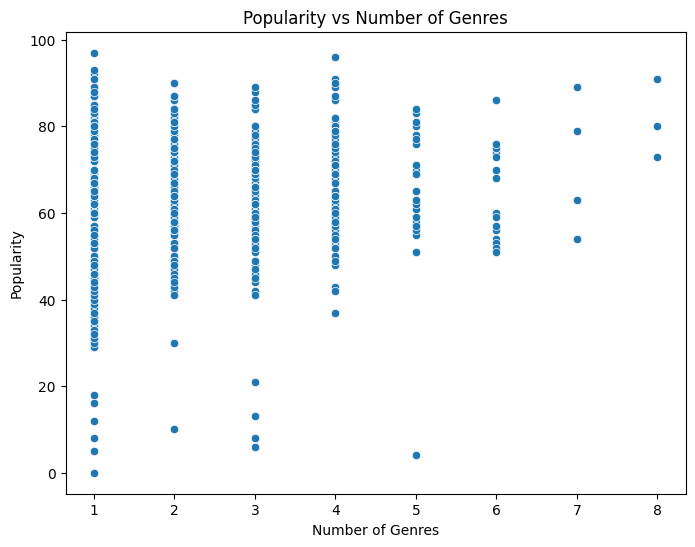

===== Step 5: Histogram of Artist Popularity =====


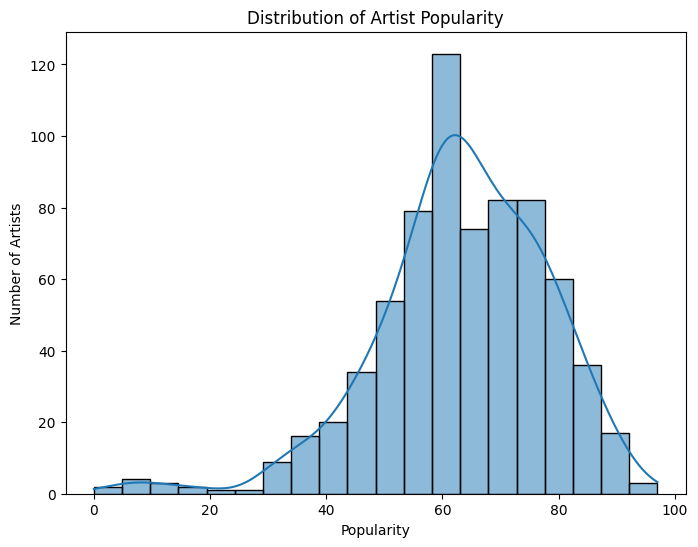

===== Step 6: Count of Single-Genre vs Multi-Genre Artists =====


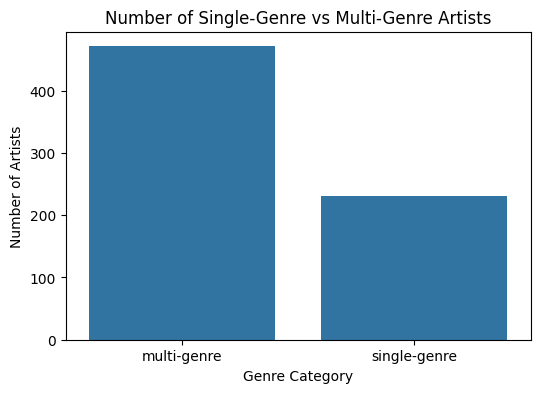

===== Step 7: Popularity vs Number of Genres (with Trend Line) =====


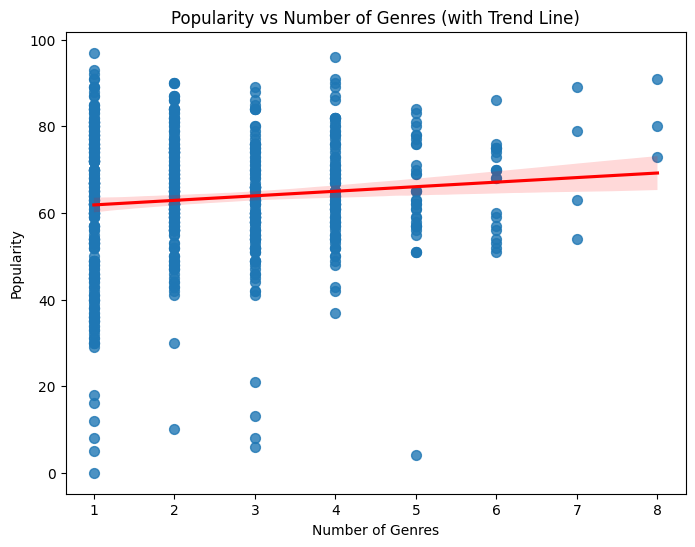

✅ All analysis and visualizations completed.


In [39]:

# Full Analysis and Visualization


print("===== Step 1: Adding genre_count and categorizing artists =====")
df_artists['genre_count'] = df_artists['genres'].apply(len)
df_artists['genre_category'] = df_artists['genre_count'].apply(lambda x: 'single-genre' if x == 1 else 'multi-genre')
print("genre_count and genre_category added.")
print("\nSample data:")
display(df_artists.head())

#Descriptive statistics

print("===== Step 2: Descriptive statistics by genre category =====")
stats = df_artists.groupby('genre_category')['popularity'].describe()
print(stats, "\n")


# Summary Statistics

print("===== Descriptive Statistics =====")
display(df_artists.describe())


#Correlation Analysis

import seaborn as sns
import matplotlib.pyplot as plt

corr = df_artists[['genre_count', 'popularity']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()



# Step 3: Boxplot - Popularity by genre category

import matplotlib.pyplot as plt
import seaborn as sns

print("===== Step 3: Boxplot - Popularity by Genre Category =====")
plt.figure(figsize=(8,6))
sns.boxplot(x='genre_category', y='popularity', data=df_artists)
plt.title('Popularity by Genre Category')
plt.xlabel('Genre Category')
plt.ylabel('Popularity')
plt.show()


#Scatter plot - genre_count vs popularity

print("===== Step 4: Scatter plot - Popularity vs Number of Genres =====")
plt.figure(figsize=(8,6))
sns.scatterplot(x='genre_count', y='popularity', data=df_artists)
plt.title('Popularity vs Number of Genres')
plt.xlabel('Number of Genres')
plt.ylabel('Popularity')
plt.show()


#Histogram of popularity

print("===== Step 5: Histogram of Artist Popularity =====")
plt.figure(figsize=(8,6))
sns.histplot(df_artists['popularity'], bins=20, kde=True)
plt.title('Distribution of Artist Popularity')
plt.xlabel('Popularity')
plt.ylabel('Number of Artists')
plt.show()


#Countplot of genre categories
print("===== Step 6: Count of Single-Genre vs Multi-Genre Artists =====")
plt.figure(figsize=(6,4))
sns.countplot(x='genre_category', data=df_artists)
plt.title('Number of Single-Genre vs Multi-Genre Artists')
plt.xlabel('Genre Category')
plt.ylabel('Number of Artists')
plt.show()


#Scatter with regression line

print("===== Step 7: Popularity vs Number of Genres (with Trend Line) =====")
plt.figure(figsize=(8,6))
sns.regplot(x='genre_count', y='popularity', data=df_artists, scatter_kws={'s':50}, line_kws={'color':'red'})
plt.title('Popularity vs Number of Genres (with Trend Line)')
plt.xlabel('Number of Genres')
plt.ylabel('Popularity')
plt.show()

print("✅ All analysis and visualizations completed.")


The heatmap shows that the correlation coefficent is 0.12 which is a very low value confirming a weak positive linear relationship
The scatterplot shows popularity scores are widley spread and the trend line indicates a very slight positive correlation.
The boxplot compares popularity between single genre and multi genre categories. we can note that the median popularity is nearly identicial

# Secondary Data

 Loaded dataset: 1000 rows, 23 columns


,Unnamed: 0,artist_name,genres,followers,artist_popularity,artist_url,track_name,album_name,release_date,duration_ms,...,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0,Ariana Grande,pop,98934105,89,https://open.spotify.com/artist/66CXWjxzNUsdJx...,we can't be friends (wait for your love),eternal sunshine,2024-03-08,228639,...,0.646,5,-8.334,1,0.0427,0.0615,0.000030,0.0740,0.295,115.842
1,1,Ariana Grande,pop,98934105,85,https://open.spotify.com/artist/66CXWjxzNUsdJx...,the boy is mine,eternal sunshine,2024-03-08,173639,...,0.630,7,-5.854,0,0.0434,0.1570,0.000000,0.0732,0.447,97.998
2,2,Ariana Grande,pop,98934105,83,https://open.spotify.com/artist/66CXWjxzNUsdJx...,intro (end of the world),eternal sunshine,2024-03-08,92400,...,0.362,10,-9.480,1,0.0416,0.6700,0.000000,0.1760,0.385,84.726
3,3,Ariana Grande,pop,98934105,80,https://open.spotify.com/artist/66CXWjxzNUsdJx...,Save Your Tears (Remix) (with Ariana Grande) -...,After Hours (Deluxe),2020-03-20,191013,...,0.825,0,-4.645,1,0.0325,0.0215,0.000024,0.0936,0.593,118.091
4,4,Ariana Grande,pop,98934105,79,https://open.spotify.com/artist/66CXWjxzNUsdJx...,"yes, and?",eternal sunshine,2024-03-08,214994,...,0.775,1,-6.614,1,0.0548,0.1900,0.000065,0.1130,0.787,118.998


🧹 After removing duplicate artists: 118 unique artists remain.

===== Descriptive Statistics =====


,artist_popularity,genre_count
count,118.000000,118.000000
mean,58.601695,2.449153
std,32.523795,2.281840
min,0.000000,0.000000
25%,35.000000,0.000000
50%,75.000000,2.000000
75%,81.000000,4.000000
max,92.000000,9.000000


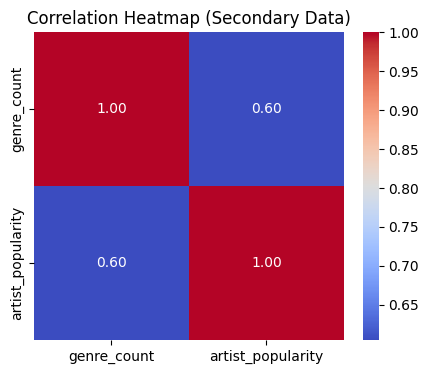

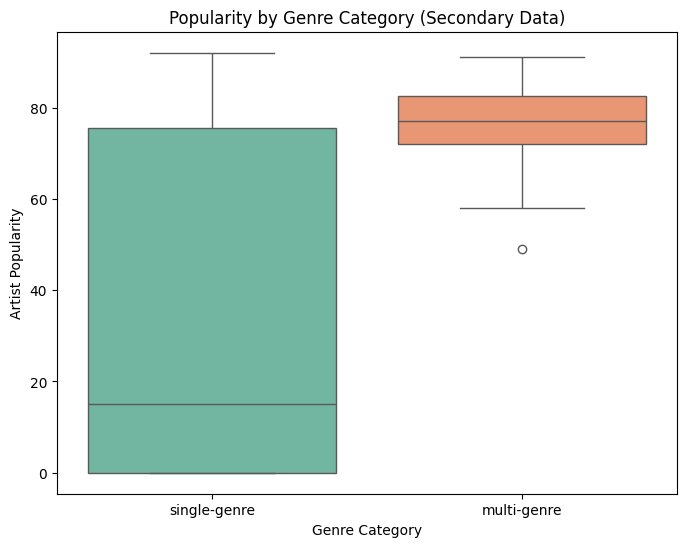

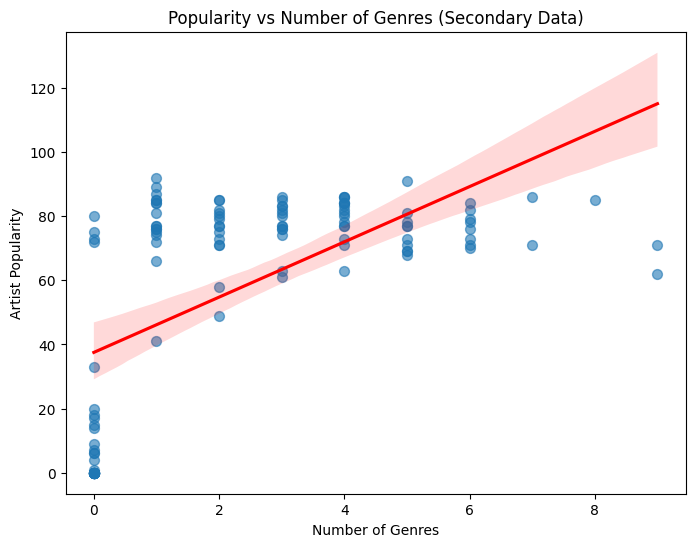

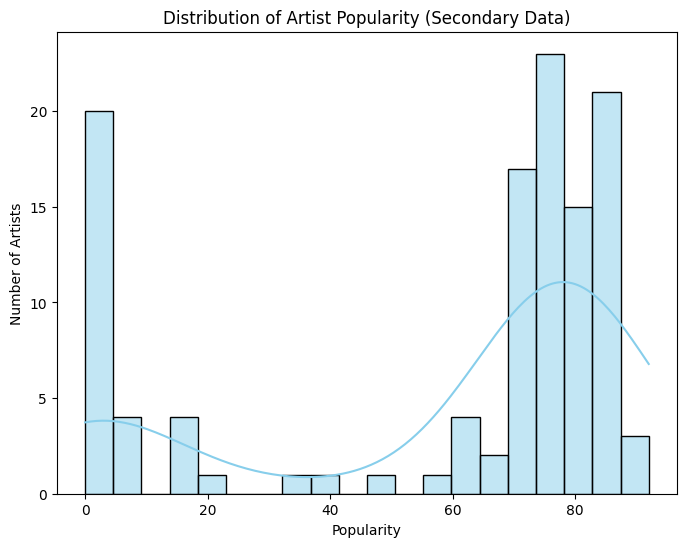

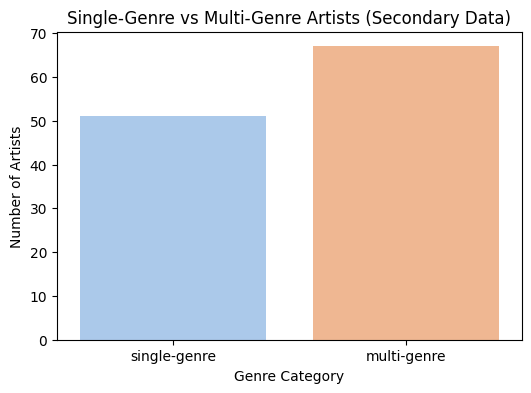

In [40]:

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sec = pd.read_csv('https://raw.githubusercontent.com/aljoharas/datascience/refs/heads/main/charts/spotifydataset.csv')
print(f" Loaded dataset: {sec.shape[0]} rows, {sec.shape[1]} columns")
display(sec.head())



if 'artist_url' in sec.columns:
    sec.drop_duplicates(subset='artist_url', inplace=True)
elif 'artist_name' in sec.columns:
    sec.drop_duplicates(subset='artist_name', inplace=True)
elif 'id' in sec.columns:
    sec.drop_duplicates(subset='id', inplace=True)

print(f"🧹 After removing duplicate artists: {len(sec)} unique artists remain.")


def count_genres(entry):
    """Counts genres for list-like or comma-separated strings; returns 0 if missing/empty."""
    if entry is None or (isinstance(entry, float) and np.isnan(entry)):
        return 0
    if isinstance(entry, list):
        return len(entry)
    if isinstance(entry, str):
        parts = [g.strip() for g in entry.split(',') if g.strip()]
        return len(parts)
    return 0

# --- Feature engineering ---
sec['genre_count'] = sec['genres'].apply(count_genres)
sec['genre_category'] = sec['genre_count'].apply(lambda x: 'single-genre' if x <= 1 else 'multi-genre')


# 1) Descriptive statistics
print("\n===== Descriptive Statistics =====")
display(sec[['artist_popularity', 'genre_count']].describe())

# 2) Correlation heatmap
plt.figure(figsize=(5,4))
sns.heatmap(sec[['genre_count', 'artist_popularity']].corr(),
            annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap (Secondary Data)')
plt.show()

# 3) Boxplot: Popularity by Genre Category
plt.figure(figsize=(8,6))
sns.boxplot(x='genre_category', y='artist_popularity', data=sec, palette='Set2')
plt.title('Popularity by Genre Category (Secondary Data)')
plt.xlabel('Genre Category')
plt.ylabel('Artist Popularity')
plt.show()

# 4) Scatter + regression: Popularity vs Number of Genres
plt.figure(figsize=(8,6))
sns.regplot(x='genre_count', y='artist_popularity', data=sec,
            scatter_kws={'s':50, 'alpha':0.6}, line_kws={'color':'red'})
plt.title('Popularity vs Number of Genres (Secondary Data)')
plt.xlabel('Number of Genres')
plt.ylabel('Artist Popularity')
plt.show()

# 5) Histogram: Distribution of Popularity
plt.figure(figsize=(8,6))
sns.histplot(sec['artist_popularity'], bins=20, kde=True, color='skyblue')
plt.title('Distribution of Artist Popularity (Secondary Data)')
plt.xlabel('Popularity')
plt.ylabel('Number of Artists')
plt.show()

# 6) Countplot: Single vs Multi-Genre
plt.figure(figsize=(6,4))
sns.countplot(x='genre_category', data=sec, palette='pastel')
plt.title('Single-Genre vs Multi-Genre Artists (Secondary Data)')
plt.xlabel('Genre Category')
plt.ylabel('Number of Artists')
plt.show()



The heatmap shows a moderate positive correlation, stronger than the one in the primary dataset.
The boxplot indicates that multi genre artists seem to to achieve higher popularity while single-genre artists show wider varability.
The scatter plot displays a clear upward trend.

# Comparison

Comparison of Primary vs Secondary Dataset Metrics:


,Metric,Primary Data,Secondary Data
0,Average Popularity,63.366097,58.601695
1,Median Popularity,64.000000,75.000000
2,Std Dev Popularity,14.808763,32.523795
3,Avg Genre Count,2.441595,2.449153
4,Median Genre Count,2.000000,2.000000
5,Single-Genre %,32.905983,43.220339
6,Multi-Genre %,67.094017,56.779661
7,Num Artists,702.000000,118.000000


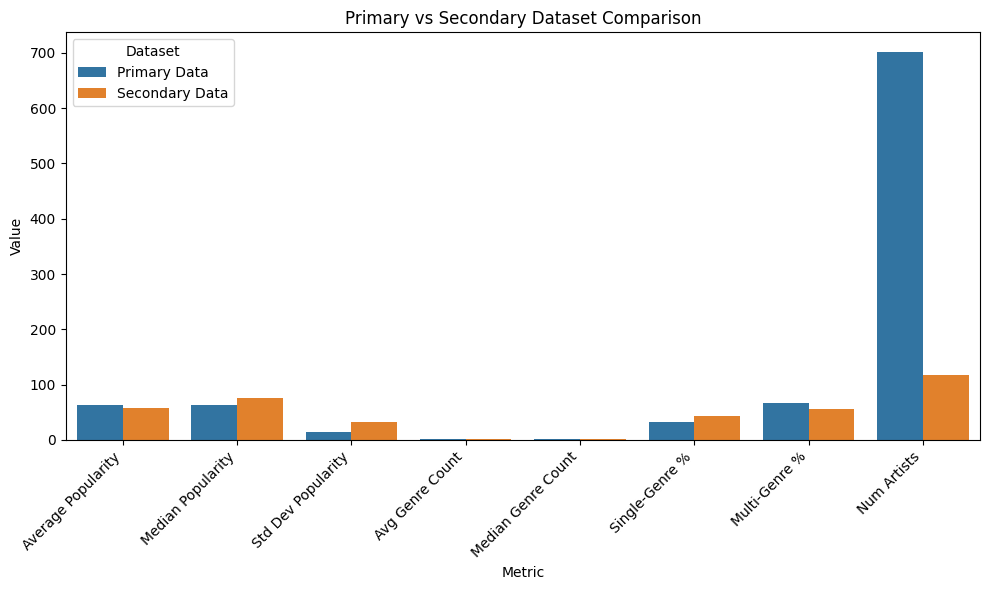

In [41]:

# COMPARISON: Primary vs Secondary Data Metrics

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt



primary = df_artists.copy()
secondary = sec.copy()

# Standardize column names
primary = primary.rename(columns={'popularity': 'artist_popularity'})
secondary = secondary.rename(columns={'artist_popularity': 'artist_popularity'})

# --- Calculate metrics for each dataset ---
primary_metrics = {
    'Average Popularity': primary['artist_popularity'].mean(),
    'Median Popularity': primary['artist_popularity'].median(),
    'Std Dev Popularity': primary['artist_popularity'].std(),
    'Avg Genre Count': primary['genre_count'].mean(),
    'Median Genre Count': primary['genre_count'].median(),
    'Single-Genre %': (primary['genre_category'].value_counts(normalize=True).get('single-genre', 0)) * 100,
    'Multi-Genre %': (primary['genre_category'].value_counts(normalize=True).get('multi-genre', 0)) * 100,
    'Num Artists': len(primary)
}

secondary_metrics = {
    'Average Popularity': secondary['artist_popularity'].mean(),
    'Median Popularity': secondary['artist_popularity'].median(),
    'Std Dev Popularity': secondary['artist_popularity'].std(),
    'Avg Genre Count': secondary['genre_count'].mean(),
    'Median Genre Count': secondary['genre_count'].median(),
    'Single-Genre %': (secondary['genre_category'].value_counts(normalize=True).get('single-genre', 0)) * 100,
    'Multi-Genre %': (secondary['genre_category'].value_counts(normalize=True).get('multi-genre', 0)) * 100,
    'Num Artists': len(secondary)
}

# --- Combine into a comparison table ---
comparison_df = pd.DataFrame({
    'Metric': list(primary_metrics.keys()),
    'Primary Data': list(primary_metrics.values()),
    'Secondary Data': list(secondary_metrics.values())
})

print("Comparison of Primary vs Secondary Dataset Metrics:")
display(comparison_df)


plt.figure(figsize=(10,6))
melted = comparison_df.melt(id_vars='Metric', var_name='Dataset', value_name='Value')
sns.barplot(data=melted, x='Metric', y='Value', hue='Dataset')
plt.xticks(rotation=45, ha='right')
plt.title('Primary vs Secondary Dataset Comparison')
plt.tight_layout()
plt.show()



This bar chart compares key metrics between the primary and secondary Spotify datasets.Both datasets show similar average and median popularity, but the secondary dataset has slightly higher variability (Std Dev) and a smaller artist pool.The primary dataset contains many more artists overall, while both datasets have a similar balance between single- and multi-genre artists, with multi-genre artists being more prevalent in both.

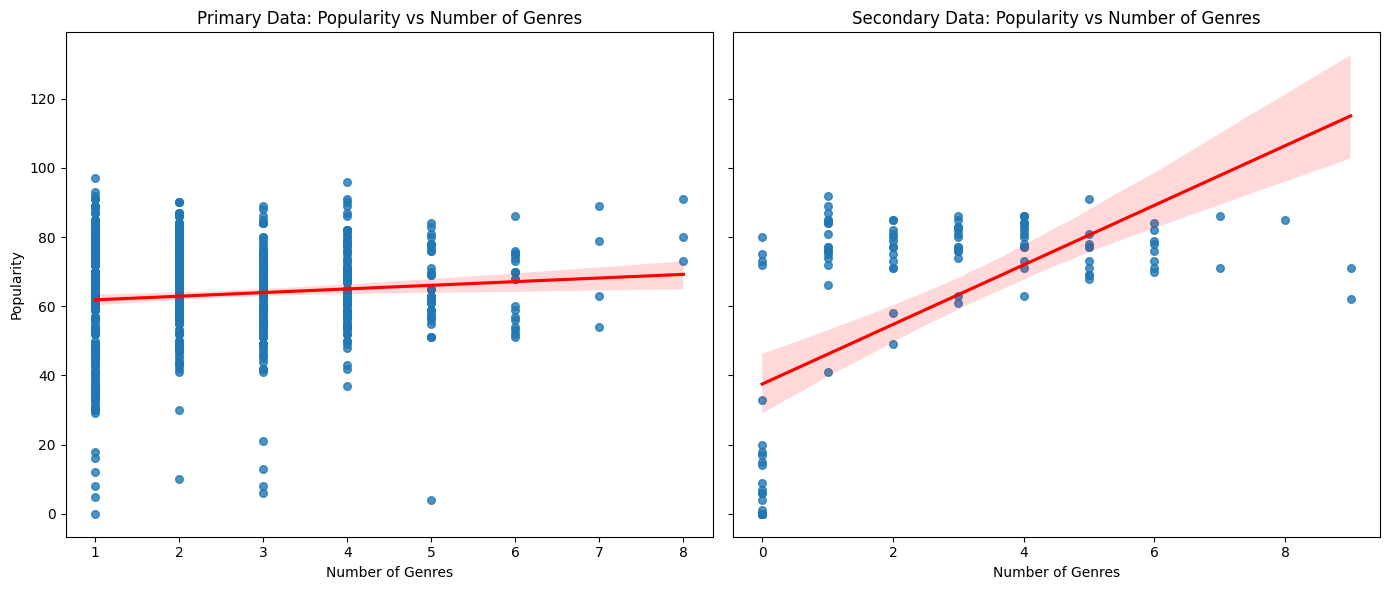

In [42]:
fig, axes = plt.subplots(1, 2, figsize=(14,6), sharey=True)

sns.regplot(x='genre_count', y='popularity', data=df_artists, ax=axes[0], scatter_kws={'s':30}, line_kws={'color':'red'})
axes[0].set_title('Primary Data: Popularity vs Number of Genres')
axes[0].set_xlabel('Number of Genres')
axes[0].set_ylabel('Popularity')

sns.regplot(x='genre_count', y='artist_popularity', data=sec, ax=axes[1], scatter_kws={'s':30}, line_kws={'color':'red'})
axes[1].set_title('Secondary Data: Popularity vs Number of Genres')
axes[1].set_xlabel('Number of Genres')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()


#Hypothesis Testing

In [43]:
import pandas as pd
import numpy as np

def count_genres(entry):
    if entry is None or (isinstance(entry, float) and np.isnan(entry)):
        return 0
    if isinstance(entry, list):
        return len(entry)
    if isinstance(entry, str):
        parts = [g.strip() for g in entry.split(',') if g.strip()]
        return len(parts)
    return 0

def ensure_genre_columns(df, pop_col, genres_col):

    out = df.copy()
    if 'artist_popularity' not in out.columns:
        out = out.rename(columns={pop_col: 'artist_popularity'})
    if 'genre_count' not in out.columns:
        out['genre_count'] = out[genres_col].apply(count_genres)
    if 'genre_category' not in out.columns:
        out['genre_category'] = out['genre_count'].apply(lambda x: 'single-genre' if x <= 1 else 'multi-genre')
    out = out.dropna(subset=['artist_popularity'])
    return out

def summarize_by_category(df):

    agg = (
        df.groupby('genre_category')['artist_popularity']
          .agg(count='count', mean='mean', std='std', median='median', min='min', max='max',
               q25=lambda x: x.quantile(0.25), q75=lambda x: x.quantile(0.75))
    )

    # rounding + formatting
    agg['count']  = agg['count'].astype(int)
    agg['mean']   = agg['mean'].round(2)
    agg['std']    = agg['std'].round(2)
    agg['median'] = agg['median'].round(1)
    agg['q25']    = agg['q25'].round(1)
    agg['q75']    = agg['q75'].round(1)
    agg['Range (Min–Max)'] = agg['min'].astype(int).astype(str) + ' – ' + agg['max'].astype(int).astype(str)

    # rename & reorder
    agg = agg.rename(columns={
        'count': 'Count',
        'mean': 'Mean Popularity',
        'std': 'Std. Deviation',
        'median': 'Median (50%)',
        'q25': '25%',
        'q75': '75%'
    })[['Count', 'Mean Popularity', 'Std. Deviation', '25%', 'Median (50%)', '75%', 'Range (Min–Max)']]

    return agg

def build_side_by_side(primary_df, secondary_df):

    p = summarize_by_category(primary_df)
    s = summarize_by_category(secondary_df)

    all_cats = sorted(set(p.index).union(set(s.index)))
    metrics = ['Count', 'Mean Popularity', 'Std. Deviation', '25%', 'Median (50%)', '75%', 'Range (Min–Max)']

    rows = []
    for cat in all_cats:
        for m in metrics:
            p_val = p.loc[cat, m] if (cat in p.index and m in p.columns) else np.nan
            s_val = s.loc[cat, m] if (cat in s.index and m in s.columns) else np.nan
            rows.append((cat, m, p_val, s_val))

    comp = pd.DataFrame(rows, columns=['Genre Category', 'Metric', 'Primary Dataset', 'Secondary Dataset'])
    return comp.set_index(['Genre Category', 'Metric'])

# ---------- Prepare inputs ----------
primary_ready   = ensure_genre_columns(df_artists, pop_col='popularity',        genres_col='genres')
secondary_ready = ensure_genre_columns(sec,        pop_col='artist_popularity', genres_col='genres')

# ---------- Compute tables ----------
primary_stats    = summarize_by_category(primary_ready)
secondary_stats  = summarize_by_category(secondary_ready)
comparison_table = build_side_by_side(primary_ready, secondary_ready)

print("Primary dataset — per-category metrics")
display(primary_stats)

print("\nSecondary dataset — per-category metrics")
display(secondary_stats)

print("\nPer-Category Metrics: Primary vs Secondary (side-by-side)")
display(comparison_table)


Primary dataset — per-category metrics


,Count,Mean Popularity,Std. Deviation,25%,Median (50%),75%,Range (Min–Max)
genre_category,,,,,,,
multi-genre,471,64.43,12.83,57.0,64.0,74.0,4 – 96
single-genre,231,61.19,18.03,48.5,64.0,75.0,0 – 97



Secondary dataset — per-category metrics


,Count,Mean Popularity,Std. Deviation,25%,Median (50%),75%,Range (Min–Max)
genre_category,,,,,,,
multi-genre,67,76.78,7.75,72.0,77.0,82.5,49 – 91
single-genre,51,34.73,37.04,0.0,15.0,75.5,0 – 92



Per-Category Metrics: Primary vs Secondary (side-by-side)


Primary Dataset Secondary Dataset
Genre Category Metric                                           
multi-genre    Count                       471                67
               Mean Popularity           64.43             76.78
               Std. Deviation            12.83              7.75
               25%                        57.0              72.0
               Median (50%)               64.0              77.0
               75%                        74.0              82.5
               Range (Min–Max)          4 – 96           49 – 91
single-genre   Count                       231                51
               Mean Popularity           61.19             34.73
               Std. Deviation            18.03             37.04
               25%                        48.5               0.0
               Median (50%)               64.0              15.0
               75%                        75.0              75.5
               Range (Min–Max)          0 – 97            0 – 92

In [49]:
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import joblib
import warnings
warnings.filterwarnings('ignore')

# -------------------------
#  Hypothesis testing
# -------------------------
print("\n Hypothesis testing =====")
single = df[df['genre_category']=='single-genre']['popularity'].dropna()
multi  = df[df['genre_category']=='multi-genre']['popularity'].dropna()
n_single, n_multi = len(single), len(multi)
print(f"Sample sizes -> single: {n_single}, multi: {n_multi}")

# Shapiro normality checks (only compute when sample size reasonable for test)
shapiro_single = shapiro_multi = (None, None)
if 3 <= n_single <= 5000:
    shapiro_single = stats.shapiro(single)
if 3 <= n_multi <= 5000:
    shapiro_multi = stats.shapiro(multi)
print("Shapiro (W, p) or (None,None) if skipped:")
print(" single:", shapiro_single)
print(" multi: ", shapiro_multi)

# Levene for equal variances
levene_stat, levene_p = stats.levene(single, multi, center='median')
print(f"\nLevene test (stat, p): {levene_stat:.4f}, {levene_p:.4g}")

# Decide test: use t-test if (approx normal or large n) else Mann-Whitney
use_ttest = False
if (shapiro_single[1] is not None and shapiro_multi[1] is not None):
    if shapiro_single[1] > 0.05 and shapiro_multi[1] > 0.05:
        use_ttest = True
else:
    # central limit theorem: for large groups, t-test is OK
    if n_single >= 30 and n_multi >= 30:
        use_ttest = True

if use_ttest:
    t_stat, t_p = stats.ttest_ind(single, multi, equal_var=(levene_p>0.05))
    test_name, test_stat, test_p = 'ttest', t_stat, t_p
else:
    u_stat, u_p = stats.mannwhitneyu(single, multi, alternative='two-sided')
    test_name, test_stat, test_p = 'mannwhitney', u_stat, u_p

def cohens_d(a,b):
    na, nb = len(a), len(b)
    if na+nb < 3:
        return np.nan
    var_a, var_b = a.var(ddof=1), b.var(ddof=1)
    pooled = np.sqrt(((na-1)*var_a + (nb-1)*var_b)/(na+nb-2)) if (na+nb-2)>0 else np.nan
    if pooled==0 or np.isnan(pooled):
        return np.nan
    return (a.mean() - b.mean())/pooled

effect = cohens_d(multi, single)  # positive -> multi > single
print(f"\nHypothesis test: {test_name}, stat={test_stat:.4f}, p={test_p:.4g}")
print(f"Cohen's d (multi - single): {effect}")
print(f"Mean popularity -> single: {single.mean():.2f}, multi: {multi.mean():.2f}")

# Save hypothesis summary
hyp = {
    'n_single': n_single, 'n_multi': n_multi,
    'test': test_name, 'stat': float(test_stat), 'p': float(test_p),
    'cohens_d': float(effect if not np.isnan(effect) else -999),
    'mean_single': float(single.mean()), 'mean_multi': float(multi.mean())
}
pd.DataFrame([hyp]).to_csv("hypothesis_test_results.csv", index=False)

# -------------------------
# correlations
# -------------------------
print("\n===== Correlations =====")
# Pearson & Spearman between number of genres and popularity
gcount = df['genre_count'].fillna(0)
pop    = df['popularity']
pearson_r, pearson_p = stats.pearsonr(gcount, pop)
spearman_r, spearman_p = stats.spearmanr(gcount, pop)
print(f"Pearson r = {pearson_r:.4f} (p={pearson_p:.4g})")
print(f"Spearman rho = {spearman_r:.4f} (p={spearman_p:.4g})")


# -------------------------
# modeling
# -------------------------
print("\n===== Modeling =====")
# Select genre_count to test its predictive power
candidate_features = ['genre_count','followers','danceability','energy','loudness','valence','tempo','duration_ms']
features = [f for f in candidate_features if f in df.columns]
if 'genre_count' not in features:
    features = ['genre_count'] + features

print("Features used:", features)

# Prepare modeling dataset
df_model = df.dropna(subset=['popularity']).copy()
X = df_model[features].fillna(df_model[features].median())
y = df_model['popularity'].values
n_samples = len(df_model)
print("Modeling samples:", n_samples)

# choose cross validation folds in safe way
cv_folds = min(5, max(2, n_samples // 50))
cv_folds = max(2, cv_folds)
print("Using cv_folds =", cv_folds)

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# scale for linear regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

results = {}

# Baseline: linear regression with genre_count
if 'genre_count' in features:
    lr_base = LinearRegression()
    lr_base.fit(X_train[['genre_count']], y_train)
    y_pred_base = lr_base.predict(X_test[['genre_count']])
    results['baseline_genre_lr'] = {
        'MAE': mean_absolute_error(y_test, y_pred_base),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_base)),
        'R2': r2_score(y_test, y_pred_base)
    }
    print("\nBaseline (genre_count) metrics:", results['baseline_genre_lr'])

# Multiple Linear Regression
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)
results['linear_regression'] = {
    'MAE': mean_absolute_error(y_test, y_pred_lr),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_lr)),
    'R2': r2_score(y_test, y_pred_lr),
    'cv_RMSE_mean': np.sqrt(-cross_val_score(lr, scaler.transform(X), y, cv=cv_folds, scoring='neg_mean_squared_error')).mean()
}
print("\nLinear Regression metrics:", results['linear_regression'])

# OLS summary for coefficient significance
X_sm = sm.add_constant(pd.DataFrame(scaler.transform(X), columns=features))
ols = sm.OLS(y, X_sm).fit()
print("\nOLS summary (coefficients & p-values):")
print(ols.summary())

# Random Forest with GridSearch (safe cv)
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
rf_param_grid = {'n_estimators':[100,300], 'max_depth':[None,8,16], 'min_samples_split':[2,5]}
rf_cv = GridSearchCV(rf, rf_param_grid, cv=max(2, min(3, cv_folds)), scoring='neg_mean_squared_error', n_jobs=-1)
rf_cv.fit(X_train, y_train)
rf_best = rf_cv.best_estimator_
y_pred_rf = rf_best.predict(X_test)
results['random_forest'] = {
    'best_params': rf_cv.best_params_,
    'MAE': mean_absolute_error(y_test, y_pred_rf),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_rf)),
    'R2': r2_score(y_test, y_pred_rf),
    'cv_RMSE_mean': np.sqrt(-rf_cv.best_score_)
}
print("\nRandom Forest metrics:", results['random_forest'])
# RF importances
try:
    fi_rf = pd.Series(rf_best.feature_importances_, index=features).sort_values(ascending=False)
    print("\nRandom Forest feature importances:\n", fi_rf)
    fi_rf.to_csv("rf_feature_importances.csv")
except Exception:
    fi_rf = None

# XGBoost if available else GradientBoosting fallback
try:
    import xgboost as xgb
    xgbr = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)
    xgbr.fit(X_train, y_train)
    y_pred_xgb = xgbr.predict(X_test)
    results['xgboost'] = {
        'MAE': mean_absolute_error(y_test, y_pred_xgb),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_xgb)),
        'R2': r2_score(y_test, y_pred_xgb)
    }
    fi_xgb = pd.Series(xgbr.feature_importances_, index=features).sort_values(ascending=False)
    print("\nXGBoost metrics & importances:")
    print(results['xgboost'])
    print(fi_xgb)
    fi_xgb.to_csv("xgb_feature_importances.csv")
    joblib.dump(xgbr, "xgboost_model.joblib")
except Exception:
    # fallback
    gbr = GradientBoostingRegressor(random_state=42)
    gbr_param_grid = {'n_estimators':[100,300], 'max_depth':[3,5]}
    gbr_cv = GridSearchCV(gbr, gbr_param_grid, cv=max(2, min(3, cv_folds)), scoring='neg_mean_squared_error', n_jobs=-1)
    gbr_cv.fit(X_train, y_train)
    gbr_best = gbr_cv.best_estimator_
    y_pred_gbr = gbr_best.predict(X_test)
    results['gradient_boosting'] = {
        'best_params': gbr_cv.best_params_,
        'MAE': mean_absolute_error(y_test, y_pred_gbr),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_gbr)),
        'R2': r2_score(y_test, y_pred_gbr),
        'cv_RMSE_mean': np.sqrt(-gbr_cv.best_score_)
    }
    print("\nGradient Boosting metrics:", results['gradient_boosting'])
    fi_gbr = pd.Series(gbr_best.feature_importances_, index=features).sort_values(ascending=False)
    print("\nGradient Boosting feature importances:\n", fi_gbr)
    fi_gbr.to_csv("gbr_feature_importances.csv")
    joblib.dump(gbr_best, "gradient_boosting_model.joblib")

# Save models & results
joblib.dump(lr, "linear_regression_model.joblib")
joblib.dump(rf_best, "random_forest_model.joblib")

# Save metrics summary
metrics_df = pd.DataFrame(results).T
metrics_df.to_csv("model_metrics_summary.csv")
print("\nSaved metrics and models to current directory.")

print("\n===== Done =====")




 Hypothesis testing =====
Sample sizes -> single: 231, multi: 471
Shapiro (W, p) or (None,None) if skipped:
 single: ShapiroResult(statistic=np.float64(0.9663757862214272), pvalue=np.float64(2.7982857244478654e-05))
 multi:  ShapiroResult(statistic=np.float64(0.9528565446820949), pvalue=np.float64(4.10569490888037e-11))

Levene test (stat, p): 37.9991, 1.195e-09

Hypothesis test: mannwhitney, stat=50755.5000, p=0.1487
Cohen's d (multi - single): 0.2199808361569674
Mean popularity -> single: 61.19, multi: 64.43

===== Correlations =====
Pearson r = 0.1020 (p=0.00686)
Spearman rho = 0.0525 (p=0.1644)

===== Modeling =====
Features used: ['genre_count']
Modeling samples: 702
Using cv_folds = 5

Baseline (genre_count) metrics: {'MAE': 12.343206099552043, 'RMSE': np.float64(16.093495218566506), 'R2': 0.014457652726265091}

Linear Regression metrics: {'MAE': 12.343206099552043, 'RMSE': np.float64(16.093495218566506), 'R2': 0.014457652726265091, 'cv_RMSE_mean': np.float64(15.389981835214328)

To improve the model, we decided to try one hot encoding the genre categories

In [51]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import warnings
warnings.filterwarnings('ignore')

# -------------------------
# 0. load / check df_artists
# -------------------------
try:
    df_artists
except NameError:

    # ensure genres parsed into lists if saved as string
    import ast, re
    def _safe_parse(x):
        if pd.isna(x): return []
        if isinstance(x, (list, tuple, set)): return list(x)
        s = str(x)
        try:
            val = ast.literal_eval(s)
            if isinstance(val, (list,tuple,set)):
                return [str(g).strip() for g in val]
        except Exception:
            pass
        s2 = re.sub(r'\s*(;|\||/|\\)\s*', ',', s)
        return [p.strip() for p in re.split(r',|\||;|/', s2) if p.strip()]
    df_artists['genres'] = df_artists['genres'].apply(_safe_parse)

# minimal checks
print("Artists:", len(df_artists))
print("Sample genres:", df_artists['genres'].head().tolist())

# require genres column as list
df_artists['genres'] = df_artists['genres'].apply(lambda g: g if isinstance(g, (list,tuple,set)) else [])

# optional: drop artists with zero genres (or keep but they will be zeros)
df = df_artists.copy()
df = df[df['genres'].map(len) > 0].reset_index(drop=True)
print("After dropping no-genre artists:", len(df))

# ensure popularity numeric
df['popularity'] = pd.to_numeric(df['popularity'], errors='coerce')
df = df.dropna(subset=['popularity']).reset_index(drop=True)

# -------------------------
# 1. Build multi-hot genre features (limit to top K)
# -------------------------
K = 50   # top K genres to keep (adjustable). Use top 50 most frequent.
from collections import Counter
genre_counter = Counter([g.lower() for lst in df['genres'] for g in lst])
top_genres = [g for g,_ in genre_counter.most_common(K)]
print(f"Top {len(top_genres)} genres sample:", top_genres[:10])

# normalize genres to lowercase so matching works
df['genres_norm'] = df['genres'].apply(lambda lst: [g.lower().strip() for g in lst])

# Build binary matrix for top genres only
mlb = MultiLabelBinarizer(classes=top_genres)
genre_matrix = mlb.fit_transform(df['genres_norm'])  # shape: (n_artists, K)
genre_df = pd.DataFrame(genre_matrix, columns=[f"genre__{g}" for g in mlb.classes_], index=df.index)


def has_other_genre(lst, top_set=set(top_genres)):
    return int(any((g not in top_set) for g in [x.lower().strip() for x in lst]))
df['has_other_genre'] = df['genres_norm'].apply(lambda lst: has_other_genre(lst, set(top_genres)))

# merge genre dummies back
df = pd.concat([df.reset_index(drop=True), genre_df.reset_index(drop=True)], axis=1)

# -------------------------
# 2. Extra numeric features
# -------------------------
# Keep genre_count, followers if available
df['genre_count'] = df['genres'].apply(lambda x: len(set([g.lower().strip() for g in x])))
print("Genre_count stats:", df['genre_count'].describe())

numeric_features = ['genre_count']
if 'followers' in df.columns:
    df['followers'] = pd.to_numeric(df['followers'], errors='coerce')
    numeric_features.append('followers')

# You can add more artist-level numeric features if present (e.g., track_count, popularity_mean etc.)

# -------------------------
# 3. Prepare modeling dataset
# -------------------------
# Features: numeric_features + genre one-hot + has_other_genre
genre_feature_cols = [c for c in df.columns if c.startswith('genre__')]
all_features = numeric_features + genre_feature_cols + ['has_other_genre']
print("Number of features:", len(all_features))

X = df[all_features].fillna(0)
y = df['popularity'].values
n_samples = len(X)
print("Modeling samples:", n_samples)

# -------------------------
# 4. Train-test split & scaling
# -------------------------
test_size = 0.2
if n_samples < 50:
    test_size = 0.33   # small sample fallback
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

scaler = StandardScaler()
# only scale numeric columns (leave binary genre dummies as-is optionally; we will scale all for linear convenience)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# safe CV fold selection
cv_folds = min(5, max(2, n_samples // 50))
cv_folds = max(2, cv_folds)
print("Using cv_folds =", cv_folds)

# -------------------------
# 5. Baseline: genre_count only
# -------------------------
from sklearn.linear_model import LinearRegression
lr_base = LinearRegression()
lr_base.fit(X_train[['genre_count']], y_train)
y_pred_base = lr_base.predict(X_test[['genre_count']])
base_metrics = {
    'MAE': mean_absolute_error(y_test, y_pred_base),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_base)),
    'R2': r2_score(y_test, y_pred_base)
}
print("Baseline (genre_count) metrics:", base_metrics)

# -------------------------
# 6. Linear Regression (one-hot + numeric)
# -------------------------
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)
lr_metrics = {
    'MAE': mean_absolute_error(y_test, y_pred_lr),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_lr)),
    'R2': r2_score(y_test, y_pred_lr),
    'cv_RMSE_mean': np.sqrt(-cross_val_score(lr, scaler.transform(X), y, cv=cv_folds, scoring='neg_mean_squared_error')).mean()
}
print("Linear Regression metrics:", lr_metrics)

# Get coefficients mapped to feature names
coef = pd.Series(lr.coef_, index=all_features).sort_values(key=lambda s: np.abs(s), ascending=False)
print("\nTop 15 Linear Regression coefficients (abs-sorted):\n", coef.head(15))

# -------------------------
# 7. Random Forest (nonlinear)
# -------------------------
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
rf_param_grid = {'n_estimators':[200,500], 'max_depth':[None, 12, 24], 'min_samples_split':[2,5]}
rf_cv = GridSearchCV(rf, rf_param_grid, cv=max(2, min(3, cv_folds)), scoring='neg_mean_squared_error', n_jobs=-1)
rf_cv.fit(X_train, y_train)
rf_best = rf_cv.best_estimator_
y_pred_rf = rf_best.predict(X_test)
rf_metrics = {
    'best_params': rf_cv.best_params_,
    'MAE': mean_absolute_error(y_test, y_pred_rf),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_rf)),
    'R2': r2_score(y_test, y_pred_rf),
    'cv_RMSE_mean': np.sqrt(-rf_cv.best_score_)
}
print("Random Forest metrics:", rf_metrics)

# RF feature importances
fi_rf = pd.Series(rf_best.feature_importances_, index=all_features).sort_values(ascending=False)
print("\nTop 20 RF feature importances:\n", fi_rf.head(20))

# -------------------------
# 8. XGBoost
# -------------------------
try:
    import xgboost as xgb
    xgbr = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)
    xgbr.fit(X_train, y_train)
    y_pred_xgb = xgbr.predict(X_test)
    xgb_metrics = {
        'MAE': mean_absolute_error(y_test, y_pred_xgb),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_xgb)),
        'R2': r2_score(y_test, y_pred_xgb)
    }
    fi_xgb = pd.Series(xgbr.feature_importances_, index=all_features).sort_values(ascending=False)
    print("XGBoost metrics:", xgb_metrics)
    print("\nTop 20 XGBoost feature importances:\n", fi_xgb.head(20))
    joblib.dump(xgbr, "xgboost_genre_model.joblib")
except Exception:
    from sklearn.ensemble import GradientBoostingRegressor
    gbr = GradientBoostingRegressor(random_state=42)
    gbr_param_grid = {'n_estimators':[200,500], 'max_depth':[3,6]}
    gbr_cv = GridSearchCV(gbr, gbr_param_grid, cv=max(2, min(3, cv_folds)), scoring='neg_mean_squared_error', n_jobs=-1)
    gbr_cv.fit(X_train, y_train)
    gbr_best = gbr_cv.best_estimator_
    y_pred_gbr = gbr_best.predict(X_test)
    xgb_metrics = {
        'best_params': gbr_cv.best_params_,
        'MAE': mean_absolute_error(y_test, y_pred_gbr),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_gbr)),
        'R2': r2_score(y_test, y_pred_gbr),
        'cv_RMSE_mean': np.sqrt(-gbr_cv.best_score_)
    }
    fi_xgb = pd.Series(gbr_best.feature_importances_, index=all_features).sort_values(ascending=False)
    print("Gradient Boosting metrics:", xgb_metrics)
    print("\nTop 20 GBT feature importances:\n", fi_xgb.head(20))
    joblib.dump(gbr_best, "gbr_genre_model.joblib")

# -------------------------
# 9. Save models & metrics
# -------------------------
joblib.dump(lr, "linear_genre_model.joblib")
joblib.dump(rf_best, "rf_genre_model.joblib")
# Save metrics summary
metrics = {
    'baseline': base_metrics,
    'linear': lr_metrics,
    'random_forest': rf_metrics,
    'xgb_like': xgb_metrics
}
pd.DataFrame(metrics).T.to_csv("genre_model_metrics.csv")
print("\nSaved models and genre_model_metrics.csv")

# -------------------------
# 10. Short interpretation printout
# -------------------------
print("\n=== Short interpretation ===")
print(f"Baseline R2: {base_metrics['R2']:.4f}, Linear R2: {lr_metrics['R2']:.4f}, RF R2: {rf_metrics['R2']:.4f}")
print("Top linear coefficients (abs):")
print(coef.head(10))
print("\nTop RF importances:")
print(fi_rf.head(10))


Artists: 702
Sample genres: [['egyptian pop', 'khaleeji'], ['egyptian hip hop', 'arabic hip hop', 'egyptian pop', 'mahraganat'], ['mahraganat', 'egyptian pop', 'egyptian shaabi'], ['mahraganat', 'egyptian pop'], ['mahraganat', 'egyptian pop', 'egyptian shaabi', 'egyptian hip hop']]
After dropping no-genre artists: 702
Top 50 genres sample: ['c-pop', 'j-pop', 't-pop', 'khaleeji', 'turkish pop', 'mandopop', 'thai pop', 'taiwanese pop', 'egyptian pop', 'cantopop']
Genre_count stats: count    702.000000
mean       2.441595
std        1.433801
min        1.000000
25%        1.000000
50%        2.000000
75%        3.000000
max        8.000000
Name: genre_count, dtype: float64
Number of features: 52
Modeling samples: 702
Using cv_folds = 5
Baseline (genre_count) metrics: {'MAE': 12.343206099552043, 'RMSE': np.float64(16.093495218566506), 'R2': 0.014457652726265091}
Linear Regression metrics: {'MAE': 8.62254837783614, 'RMSE': np.float64(13.297248475034776), 'R2': 0.327181216148959, 'cv_RMSE_me